In [1]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_graphml('../../scripture_graph.graphml')

# Drop topic nodes/references.
print(graph.number_of_nodes(), graph.number_of_edges())
drop = set()
for node in graph.nodes:
    if graph.nodes[node]['kind'] == 'topic':
        drop.add(node)
for node in drop:
    graph.remove_node(node)
print(graph.number_of_nodes(), graph.number_of_edges())

48566 166449
41995 45985


In [3]:
# Count the fraction of reciprocal references...there seem to be a lot of them.
unique = []
for a, b in graph.edges:
    if (b, a) not in graph.edges:
        unique.append((a, b))
print(len(unique), len(graph.edges), len(unique) / len(graph.edges), 1 - len(unique) / len(graph.edges))

7907 45985 0.17194737414374253 0.8280526258562575


# Reference Counts

In [4]:
len(graph.nodes)

41995

In [5]:
len(graph.edges)

45985

In [6]:
rows = []
# NOTE(kearnes): We are only considering "in" references.
for node, degree in graph.in_degree():
    row = {'node': node, 'degree': degree}
    row.update(graph.nodes[node])
    rows.append(row)
degree = pd.DataFrame(rows)
print(degree.shape)
degree.head()

(41995, 7)


,node,degree,kind,volume,book,chapter,verse
0,1 Chr. 1:1,0,verse,Old Testament,1 Chr.,1,1
1,1 Chr. 1:2,0,verse,Old Testament,1 Chr.,1,2
2,1 Chr. 1:3,0,verse,Old Testament,1 Chr.,1,3
3,1 Chr. 1:4,2,verse,Old Testament,1 Chr.,1,4
4,1 Chr. 1:5,0,verse,Old Testament,1 Chr.,1,5


In [7]:
alone = (degree.degree == 0).sum()
alone / len(degree)

0.5576616263840933

In [8]:
count = (degree.degree >= 1) & (degree.degree <= 5)
count.sum() / len(degree)

0.406905583998095

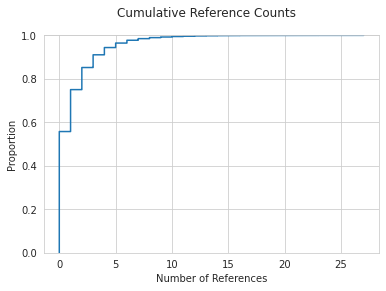

In [9]:
sns.set_style('whitegrid')

fig, ax = subplots()
sns.ecdfplot(data=degree, x='degree', ax=ax)
suptitle('Cumulative Reference Counts')
ax.set_xlabel('Number of References')
fig.savefig('count-cdf.png', dpi=300, bbox_inches='tight')

In [10]:
sort = degree.sort_values('degree', ascending=False)
for volume in sort.volume.unique():
    print(sort[sort.volume == volume].head())

            node  degree   kind                  volume book  chapter  verse
35494   D&C 1:38      27  verse  Doctrine and Covenants  D&C        1     38
36839   D&C 17:1      27  verse  Doctrine and Covenants  D&C       17      1
35470   D&C 1:14      24  verse  Doctrine and Covenants  D&C        1     14
38772  D&C 88:63      21  verse  Doctrine and Covenants  D&C       88     63
35472   D&C 1:16      21  verse  Doctrine and Covenants  D&C        1     16
              node  degree   kind          volume   book  chapter  verse
31384  1 Ne. 17:35      25  verse  Book of Mormon  1 Ne.       17     35
39664    Hel. 12:3      25  verse  Book of Mormon   Hel.       12      3
32109  2 Ne. 25:20      23  verse  Book of Mormon  2 Ne.       25     20
31439  1 Ne. 19:10      23  verse  Book of Mormon  1 Ne.       19     10
41961    Omni 1:15      20  verse  Book of Mormon   Omni        1     15
             node  degree   kind                volume   book  chapter  verse
41051  Moses 6:57     

# Reference Patterns

In [11]:
# Look at pairs of standard works (or even books). What are the cross-reference patterns?

# TODO:
# * Compare to normalization by the number of verses (relative reference propensity). The absolute is interesting too.

In [12]:
volume_totals = collections.defaultdict(int)
for node in graph.nodes:
    volume_totals[graph.nodes[node]['volume']] += 1
volume_totals

defaultdict(int,
            {'Old Testament': 23145,
             'New Testament': 7957,
             'Book of Mormon': 6604,
             'Pearl of Great Price': 635,
             'Doctrine and Covenants': 3654})

In [13]:
book_totals = collections.defaultdict(int)
for node in graph.nodes:
    book_totals[graph.nodes[node]['book']] += 1
book_totals

defaultdict(int,
            {'1 Chr.': 942,
             '1 Cor.': 437,
             '1 Jn.': 105,
             '1 Kgs.': 816,
             '1 Pet.': 105,
             '1 Sam.': 810,
             '1 Thes.': 89,
             '1 Tim.': 113,
             '2 Chr.': 822,
             '2 Cor.': 257,
             '2 Jn.': 13,
             '2 Kgs.': 719,
             '2 Pet.': 61,
             '2 Sam.': 695,
             '2 Thes.': 47,
             '2 Tim.': 83,
             '3 Jn.': 14,
             'Acts': 1007,
             'Amos': 146,
             'Col.': 95,
             'Dan.': 357,
             'Deut.': 959,
             'Eccl.': 222,
             'Eph.': 155,
             'Esth.': 167,
             'Ex.': 1213,
             'Ezek.': 1273,
             'Ezra': 280,
             'Gal.': 149,
             'Gen.': 1533,
             'Hab.': 56,
             'Hag.': 38,
             'Heb.': 303,
             'Hosea': 197,
             'Isa.': 1292,
             'James': 108,
             

In [14]:
volume_degree = {}
for key in volume_totals:
    mask = degree.volume == key
    volume_degree[key] = degree[mask].degree.values.sum()
volume_degree

{'Old Testament': 17017,
 'New Testament': 7260,
 'Book of Mormon': 12278,
 'Pearl of Great Price': 1435,
 'Doctrine and Covenants': 7995}

In [15]:
relative_volume_degree = {}
for key in volume_totals:
    relative_volume_degree[key] = volume_degree[key] / volume_totals[key]
relative_volume_degree

{'Old Testament': 0.7352343918772953,
 'New Testament': 0.9124041724267941,
 'Book of Mormon': 1.8591762568140522,
 'Pearl of Great Price': 2.2598425196850394,
 'Doctrine and Covenants': 2.1880131362889985}

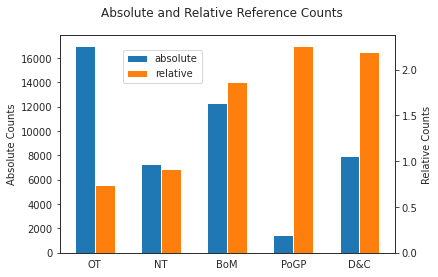

In [16]:
sns.set_style('white')
colors = sns.color_palette()
fig, ax = subplots()
ax.bar(range(5), volume_degree.values(), color=colors[0], label='absolute', width=-0.3, align='edge')
ax.set_ylabel('Absolute Counts')
ax2 = ax.twinx()
ax2.bar(range(5), relative_volume_degree.values(), color=colors[1], label='relative', width=0.3, align='edge')
ax2.set_ylabel('Relative Counts')
ax.set_xticks(range(5))
ax.set_xticklabels([graph_lib.VOLUMES_SHORT[key] for key in volume_degree])
figlegend(loc=(0.28, 0.7))
suptitle('Absolute and Relative Reference Counts')
fig.savefig('count-bar.png', dpi=300, bbox_inches='tight')

In [17]:
volume_counts = collections.defaultdict(int)
book_counts = collections.defaultdict(int)
for target in graph.nodes:
    target_volume = graph.nodes[target]['volume']
    target_book = graph.nodes[target]['book']
    for source, _ in graph.in_edges(target):
        source_volume = graph.nodes[source]['volume']
        source_book = graph.nodes[source]['book']
        volume_counts[(source_volume, target_volume)] += 1
        book_counts[(source_book, target_book)] += 1

rows = []
for (source, target), count in volume_counts.items():
    rows.append({
        'source': graph_lib.VOLUMES_SHORT[source], 
        'target': graph_lib.VOLUMES_SHORT[target], 
        'count': count,
        'relative_count': count / volume_totals[target],
    })
volume_data = pd.DataFrame(rows)
print(volume_data.head())
        
rows = []
for (source, target), count in book_counts.items():
    rows.append({
        'source': source, 
        'target': target, 
        'count': count,
        'relative_count': count / book_totals[target],
    })
book_data = pd.DataFrame(rows)
print(book_data.head())

  source target  count  relative_count
0     OT     OT  11270        0.486930
1   PoGP     OT    369        0.015943
2    BoM     OT   2438        0.105336
3    D&C     OT   1841        0.079542
4     NT     OT   1099        0.047483
   source  target  count  relative_count
0    Gen.  1 Chr.     31        0.032909
1   Moses  1 Chr.      3        0.003185
2   Ether  1 Chr.      2        0.002123
3    Abr.  1 Chr.      1        0.001062
4  1 Sam.  1 Chr.     19        0.020170


In [18]:
order = []
for volume in graph_lib.VOLUMES.keys():
    if volume == 'Study Helps':
        continue
    order.append(volume)
order_short = [graph_lib.VOLUMES_SHORT[key] for key in order]
df = volume_data.pivot('source', 'target', 'count').reindex(index=order_short, columns=order_short)
df

target,OT,NT,BoM,D&C,PoGP
source,,,,,
OT,11270,1103,2352,1866,453
NT,1099,2849,858,1255,84
BoM,2438,1378,7902,1070,261
D&C,1841,1828,992,3626,305
PoGP,369,102,174,178,332


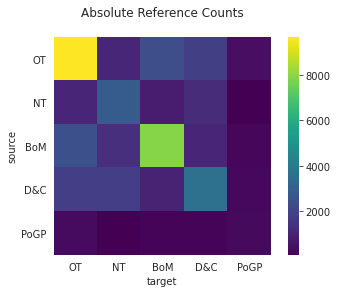

In [19]:
fig, ax = subplots()
g = sns.heatmap(df, cmap='viridis', square=True, ax=ax, robust=True)
ax.set_yticklabels(order_short, rotation=0)
ax.set_title('Absolute Reference Counts\n')
fig.savefig('absolute-volumes.png', dpi=300, bbox_inches='tight')

In [20]:
df = volume_data.pivot('source', 'target', 'relative_count').reindex(index=order_short, columns=order_short)
df

target,OT,NT,BoM,D&C,PoGP
source,,,,,
OT,0.486930,0.138620,0.356148,0.510673,0.713386
NT,0.047483,0.358050,0.129921,0.343459,0.132283
BoM,0.105336,0.173181,1.196548,0.292830,0.411024
D&C,0.079542,0.229735,0.150212,0.992337,0.480315
PoGP,0.015943,0.012819,0.026348,0.048714,0.522835


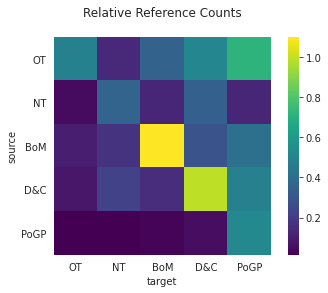

In [21]:
fig, ax = subplots()
g = sns.heatmap(df, cmap='viridis', square=True, ax=ax, robust=True)
ax.set_yticklabels(order_short, rotation=0)
ax.set_title('Relative Reference Counts\n')
fig.savefig('relative-volumes.png', dpi=300, bbox_inches='tight')

In [22]:
order = []
for volume, books in graph_lib.VOLUMES.items():
    if volume == 'Study Helps':
        continue
    order.extend(books)
df = book_data.pivot('source', 'target', 'count').reindex(index=order, columns=order)
df

target,Gen.,Ex.,Lev.,Num.,Deut.,Josh.,Judg.,Ruth,1 Sam.,2 Sam.,...,4 Ne.,Morm.,Ether,Moro.,D&C,Moses,Abr.,JS—M,JS—H,A of F
source,,,,,,,,,,,,,,,,,,,,,
Gen.,604.0,44.0,4.0,22.0,37.0,16.0,12.0,3.0,9.0,8.0,...,3.0,11.0,32.0,8.0,163.0,105.0,93.0,1.0,4.0,1.0
Ex.,44.0,443.0,42.0,72.0,107.0,27.0,12.0,NaN,18.0,8.0,...,NaN,4.0,8.0,5.0,143.0,28.0,13.0,NaN,5.0,1.0
Lev.,3.0,42.0,80.0,31.0,38.0,4.0,5.0,3.0,4.0,1.0,...,NaN,2.0,2.0,4.0,66.0,4.0,1.0,NaN,1.0,NaN
Num.,23.0,72.0,31.0,89.0,73.0,41.0,10.0,NaN,5.0,6.0,...,NaN,NaN,3.0,NaN,39.0,5.0,1.0,NaN,2.0,2.0
Deut.,37.0,107.0,38.0,73.0,128.0,37.0,16.0,7.0,11.0,9.0,...,NaN,2.0,5.0,3.0,110.0,10.0,4.0,1.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Moses,96.0,30.0,1.0,5.0,12.0,1.0,1.0,NaN,2.0,NaN,...,NaN,4.0,7.0,4.0,112.0,199.0,43.0,2.0,3.0,1.0
Abr.,63.0,8.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,1.0,...,NaN,1.0,1.0,NaN,31.0,31.0,44.0,NaN,1.0,NaN
JS—M,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23.0,2.0,NaN,4.0,NaN,NaN


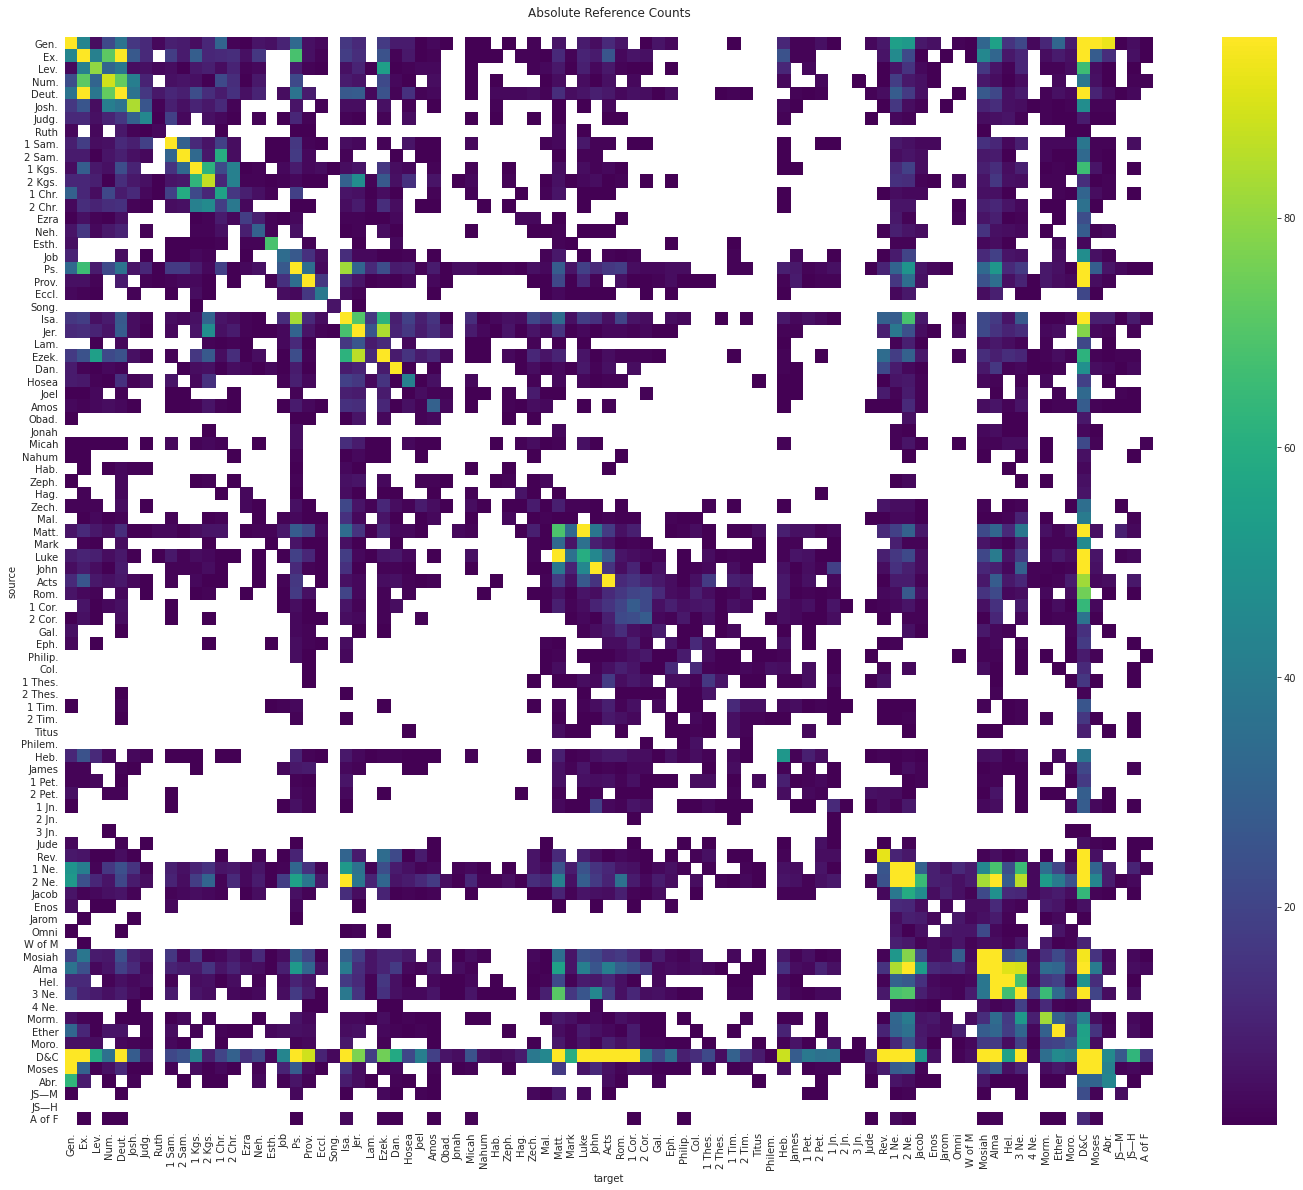

In [23]:
fig, ax = subplots(figsize=(25, 20))
g = sns.heatmap(df, cmap='viridis', square=True, ax=ax, robust=True)
ax.set_title('Absolute Reference Counts\n')
fig.savefig('absolute-books.png', dpi=300, bbox_inches='tight')

In [24]:
df = book_data.pivot('source', 'target', 'relative_count').reindex(index=order, columns=order)
df

target,Gen.,Ex.,Lev.,Num.,Deut.,Josh.,Judg.,Ruth,1 Sam.,2 Sam.,...,4 Ne.,Morm.,Ether,Moro.,D&C,Moses,Abr.,JS—M,JS—H,A of F
source,,,,,,,,,,,,,,,,,,,,,
Gen.,0.393999,0.036274,0.004657,0.017081,0.038582,0.024316,0.019417,0.035294,0.011111,0.011511,...,0.061224,0.048458,0.073903,0.049080,0.044609,0.294944,0.683824,0.018182,0.053333,0.076923
Ex.,0.028702,0.365210,0.048894,0.055901,0.111575,0.041033,0.019417,NaN,0.022222,0.011511,...,NaN,0.017621,0.018476,0.030675,0.039135,0.078652,0.095588,NaN,0.066667,0.076923
Lev.,0.001957,0.034625,0.093132,0.024068,0.039625,0.006079,0.008091,0.035294,0.004938,0.001439,...,NaN,0.008811,0.004619,0.024540,0.018062,0.011236,0.007353,NaN,0.013333,NaN
Num.,0.015003,0.059357,0.036088,0.069099,0.076121,0.062310,0.016181,NaN,0.006173,0.008633,...,NaN,NaN,0.006928,NaN,0.010673,0.014045,0.007353,NaN,0.026667,0.153846
Deut.,0.024136,0.088211,0.044237,0.056677,0.133472,0.056231,0.025890,0.082353,0.013580,0.012950,...,NaN,0.008811,0.011547,0.018405,0.030104,0.028090,0.029412,0.018182,0.040000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Moses,0.062622,0.024732,0.001164,0.003882,0.012513,0.001520,0.001618,NaN,0.002469,NaN,...,NaN,0.017621,0.016166,0.024540,0.030651,0.558989,0.316176,0.036364,0.040000,0.076923
Abr.,0.041096,0.006595,NaN,0.000776,NaN,0.003040,NaN,NaN,NaN,0.001439,...,NaN,0.004405,0.002309,NaN,0.008484,0.087079,0.323529,NaN,0.013333,NaN
JS—M,0.000652,NaN,NaN,NaN,0.001043,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006294,0.005618,NaN,0.072727,NaN,NaN


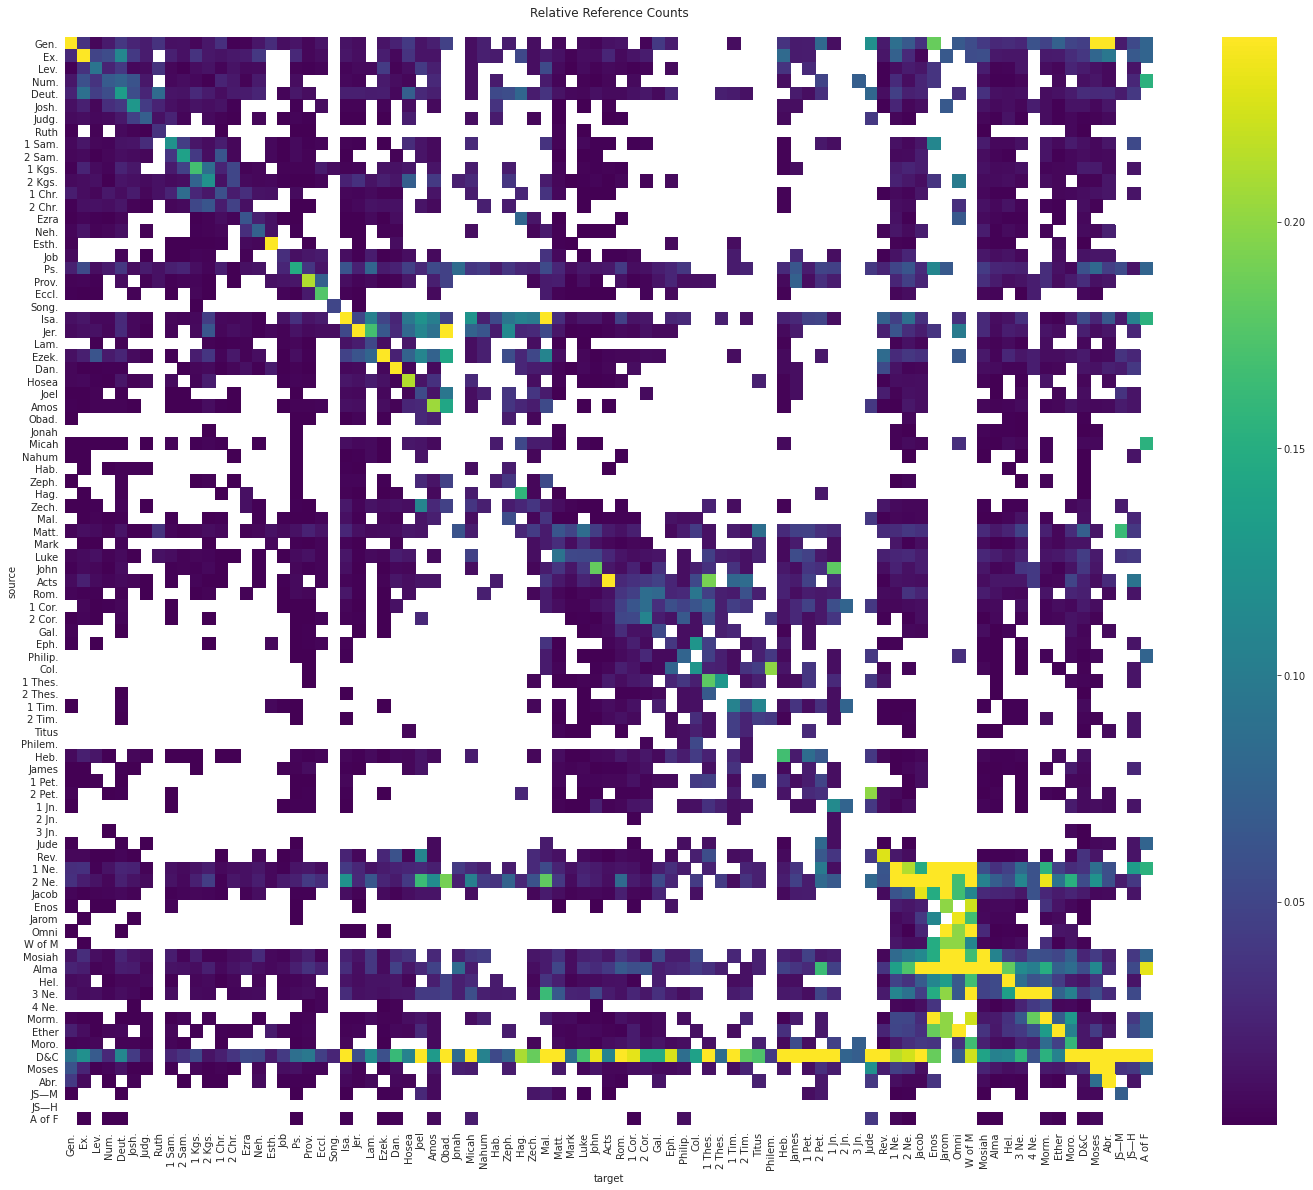

In [25]:
fig, ax = subplots(figsize=(25, 20))
g = sns.heatmap(df, cmap='viridis', square=True, ax=ax, robust=True)
ax.set_title('Relative Reference Counts\n')
fig.savefig('relative-books.png', dpi=300, bbox_inches='tight')